# Examine trans effect of TP53 Hotspot mutation in Ovarian Cancer

### Specifically examine Protein Abundance of TP53, AURKA, CDK1, XPO1, and STK11

#### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import cptac
import cptac.utils as ut

import seaborn as sns
import matplotlib.pyplot as plt

#Use Ovarian cancer object
co = cptac.Ovarian()

## Use parse hotspot utility to analyze TP53 hotspot mutation in Ovarian cancer

#### Get somatic mutation data from cptac

In [2]:
somatic_mutations = co.get_somatic_mutation()

#### Use parse hotspot utility

In [3]:
vis, binary, detailed, dictionary = ut.parse_hotspot('../../HotspotClusterFiles/ovarian_somatic_38.maf.3D_Proximity.pairwise.recurrence.l0.r10.clusters', somatic_mutations)

In [4]:
vis

,hotspot_id,patients_within
0,ADH1A,2.0
1,CDCA2,3.0
2,CPS1,2.0
3,EIF4A1,3.0
4,FGF18,3.0
5,GCA,2.0
6,GOT1,2.0
7,HNRNPM,3.0
8,KDM2A,2.0
9,KHK,2.0


As we can see, TP53 has 5 hotspots in Ovarian cancer

#### Select only TP53 Hotspots

In [5]:
#There are 5 TP53 hotspots
TP53_Hotspots = detailed[['TP53','TP53_1','TP53_2','TP53_3','TP53_4']]
TP53_Hotspots.head()

,TP53,TP53_1,TP53_2,TP53_3,TP53_4
sample_id,,,,,
S002,No,No,No,No,No
S006,No,No,No,No,No
S007,No,Yes_HS,No,No,No
S009,No,Yes,No,No,No
S011,No,Yes,No,No,No


#### Make binary column for samples that have a TP53 Hotspot Mutation

In [6]:
TP53_Hotspots['Hotspot_Mutation'] = ''
for ind, row in TP53_Hotspots.iterrows():
    for col in TP53_Hotspots.columns:
        if row[col] == 'Yes_HS':
            TP53_Hotspots.loc[ind,'Hotspot_Mutation'] = 'TP53_Hotspot_Mutation'
        if row[col] == 'Yes':
            TP53_Hotspots.loc[ind,'Hotspot_Mutation'] = 'TP53_Hotspot_Mutation'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

#### Grab only the binary yes/no hotspot mutation

In [7]:
binary_hotspots = TP53_Hotspots['Hotspot_Mutation']

#### Get Proteomic data, append Binary hotspot mutation column

In [8]:
#Use join omics to mutations
proteomics_df = co.join_omics_to_mutations(omics_genes=['TP53','AURKA','CDK1','XPO1','STK11'], omics_df_name='proteomics', mutations_genes='TP53')

#Remove multiindex from df
proteomics_df = co.reduce_multiindex(proteomics_df, levels_to_drop='Database_ID')

#Remove Non-Tumor Samples
proteomics_df = proteomics_df.loc[proteomics_df['Sample_Status'] == 'Tumor']

#Remove columns that are not needed
proteomics_df = proteomics_df.drop(['TP53_Location','Sample_Status'],axis=1)
proteomics_df['TP53_Hotspot_Mutation'] = binary_hotspots

#Show df
proteomics_df.head()

Name,AURKA_proteomics,CDK1_proteomics,STK11_proteomics,TP53_proteomics,XPO1_proteomics,TP53_Mutation,TP53_Mutation_Status,TP53_Hotspot_Mutation
Patient_ID,,,,,,,,
S002,-0.621241,-0.745212,0.189093,-1.600876,0.191521,[Frame_Shift_Del],Single_mutation,
S006,0.416099,0.466097,-0.256113,-1.685874,0.473283,[Frame_Shift_Del],Single_mutation,
S007,-0.302865,0.272087,-0.083314,0.846640,0.366800,[Missense_Mutation],Single_mutation,TP53_Hotspot_Mutation
S009,0.424056,-0.002221,-0.267422,0.419432,0.077574,[Missense_Mutation],Single_mutation,TP53_Hotspot_Mutation
S011,NaN,0.109734,0.171339,-2.459607,0.170988,[Frame_Shift_Ins],Single_mutation,TP53_Hotspot_Mutation


#### Classify every sample according to TP53 Mutation Status. Use: Wildtype, Hotspot_Missense, Other_Missense, Truncation

In [9]:
for ind, row in proteomics_df.iterrows():
    #Classify Hotspot Missense Mutations
    if row['TP53_Hotspot_Mutation'] == 'TP53_Hotspot_Mutation':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Hotspot_Missense'
        
    #Classify Truncation Mutations
    if 'Frame_Shift_Ins' in row['TP53_Mutation'] or 'Frame_Shift_Del' in row['TP53_Mutation'] or 'Nonsense_Mutation' in row['TP53_Mutation']:
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Truncation'
        
    #Classify Wildtype
    if row['TP53_Mutation_Status'] == 'Wildtype_Tumor':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Wildtype'
        
    #Classify Other Missense Mutations
    if row['TP53_Hotspot_Mutation'] != 'TP53_Hotspot_Mutation':
        if 'Missense_Mutation' in row['TP53_Mutation'] or 'In_Frame_Del' in row['TP53_Mutation'] or 'In_Frame_Ins' in row['TP53_Mutation'] or 'Splice_Site' in row['TP53_Mutation']:
            proteomics_df.loc[ind, 'TP53_Categorical'] = 'Other_Missense'

#Drop columns we no longer need, display df
proteomics_df = proteomics_df.drop(['TP53_Mutation', 'TP53_Mutation_Status', 'TP53_Hotspot_Mutation'], axis = 1)
proteomics_df

Name,AURKA_proteomics,CDK1_proteomics,STK11_proteomics,TP53_proteomics,XPO1_proteomics,TP53_Categorical
Patient_ID,,,,,,
S002,-0.621241,-0.745212,0.189093,-1.600876,0.191521,Truncation
S006,0.416099,0.466097,-0.256113,-1.685874,0.473283,Truncation
S007,-0.302865,0.272087,-0.083314,0.846640,0.366800,Hotspot_Missense
S009,0.424056,-0.002221,-0.267422,0.419432,0.077574,Hotspot_Missense
S011,NaN,0.109734,0.171339,-2.459607,0.170988,Truncation
S012,NaN,0.414026,0.290676,-1.017320,0.234806,Wildtype
S013,-0.564741,-1.287543,0.565342,-0.749927,0.645797,Hotspot_Missense
S015,NaN,1.357564,-0.559616,1.213573,1.006944,Hotspot_Missense
S016,NaN,0.031561,0.132389,-1.370643,0.326999,Truncation


### Perform t-tests on each protein, comparing Hotspot-Wildtype, Hotspot-Truncation, and Hotspot-Other Missense Mutations

In [10]:
for col in proteomics_df:
    if col != 'TP53_Categorical':
        hotspot_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Hotspot_Missense'][col].dropna()
        truncation_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Truncation'][col].dropna()
        other_missense_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Other_Missense'][col].dropna()
        wt_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Wildtype'][col]
        
        #Hotspot-WT comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, wt_df)
        print("Omics: ", col, "\nComparison: Hotspot vs. Wildtype \nP-Value: ", str(pval))
        
        #Hotspot-Truncation comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, truncation_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Truncation \nP-Value: ", str(pval))
        
        #Hotspot-Other Missense comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, other_missense_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Other Missense \nP-Value: ", str(pval))
        print("\n\n")
        

Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.7549601354426911

Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.7225436549599691



Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  0.5039681349218603

Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.35674269317025686

Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.37010530799241703



Omics:  STK11_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  0.5210562006692321

Omics:  STK11_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.7118834704450945

Omics:  STK11_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.7749149587587945



Omics:  TP53_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  0.012351058533685663

Omics:  TP53_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  1.922297919566

#### Reformat dataframe for plot

In [11]:
plotdf = pd.melt(proteomics_df, id_vars='TP53_Categorical', var_name='Protein', value_name='Abundance')
plotdf = plotdf.replace({'AURKA_proteomics':'AURKA','XPO1_proteomics':'XPO1','TP53_proteomics':'TP53','CDK1_proteomics':'CDK1','STK11_proteomics':'STK11'})
plotdf = plotdf.replace({'Hotspot_Missense':'Hotspot Missense','Other_Missense':'Other Missense'})

### Make plot illustrating proteomic abundance

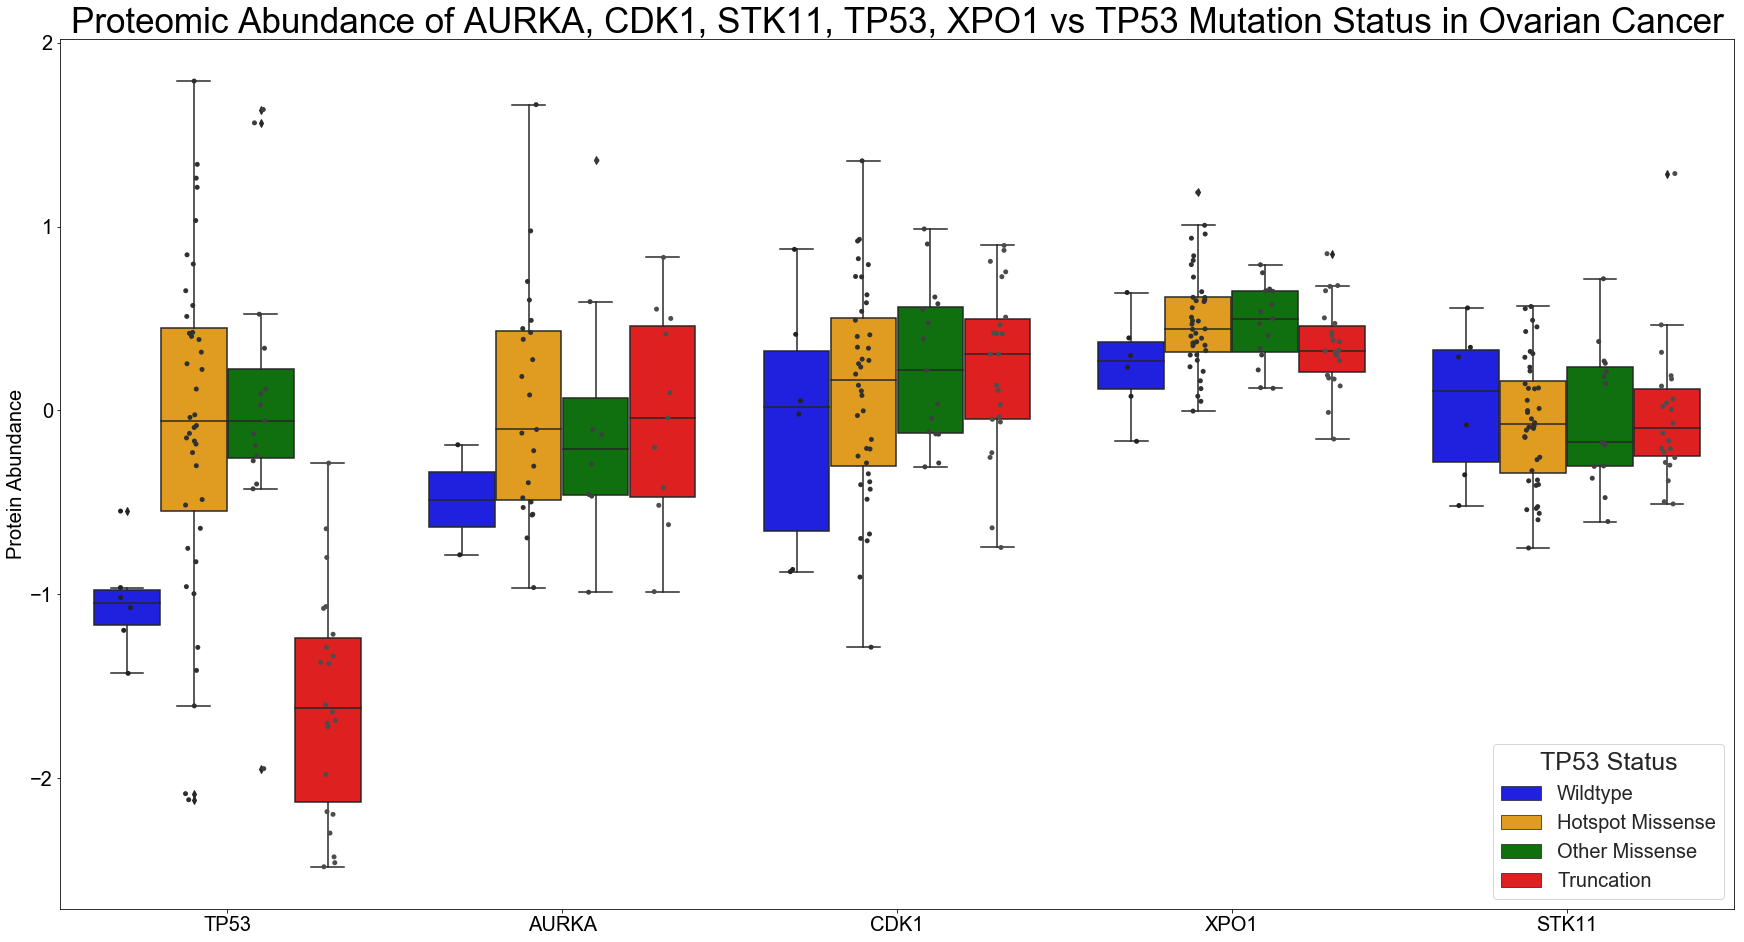

In [12]:
#Set dimensions and Colors
a4_dims = (30, 16)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Wildtype": "blue", "Hotspot Missense": "orange", "Other Missense":"green","Truncation":"red"}

#Make Boxplot
plot = sns.boxplot(data=plotdf, y = 'Abundance', x='Protein', hue='TP53_Categorical', palette=my_pal, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'], order=['TP53','AURKA','CDK1','XPO1','STK11'])

#Overlay Striplot
plot = sns.stripplot(data=plotdf, y = 'Abundance', x='Protein', hue='TP53_Categorical', color='.3', jitter=True, dodge=True, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'],order=['TP53','AURKA','CDK1','XPO1','STK11'])

#Change Style and label sizes
plot.tick_params(labelsize=20)
plot.set_xlabel('')
plot.set_ylabel('Protein Abundance', fontsize='20')
plot.set_title('Proteomic Abundance of AURKA, CDK1, STK11, TP53, XPO1 vs TP53 Mutation Status in Ovarian Cancer', fontsize = '35')
sns.set_style("white")

#Adjust the Legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],['Wildtype','Hotspot Missense','Other Missense','Truncation'], title='TP53 Status', fontsize='20', frameon=True)
plot.get_legend().get_title().set_fontsize('25')


### Conclusions:

The only significant comparisons of TP53 Hotspot mutation were TP53 Hotspot Missense vs Wildtype, with a p-value of 0.000778, and TP53 Hotspot Missense vs. Truncation with a p-value of 7.4086e-11

In [13]:
dictionary

{'ADH1A': ['p.S118G', 'p.V117L'],
 'CDCA2': ['p.R415H', 'p.E178K', 'p.K179N'],
 'CPS1': ['p.R1459L', 'p.R1460M'],
 'EIF4A1': ['p.G191R', 'p.R190H'],
 'FGF18': ['p.A144T', 'p.S143L'],
 'GCA': ['p.A60D', 'p.T56N'],
 'GOT1': ['p.F119L', 'p.S286C'],
 'HNRNPM': ['p.F699L', 'p.H678N'],
 'KDM2A': ['p.E636K', 'p.P651S'],
 'KHK': ['p.E126D', 'p.S242L'],
 'NTRK1': ['p.R445I', 'p.R445S'],
 'PFKFB1': ['p.D183Y', 'p.L176R'],
 'POLI': ['p.P317T', 'p.T406N'],
 'PPP2R1A': ['p.R183W', 'p.S219L'],
 'RANBP2': ['p.L2108S', 'p.Q2121R'],
 'RPS11': ['p.E31Q', 'p.T28N'],
 'SP100': ['p.F727S', 'p.I726M'],
 'TP53': ['p.R248L', 'p.R248Q', 'p.R248W'],
 'TP53_1': ['p.C275Y', 'p.K132N', 'p.R273C', 'p.R273H', 'p.R282W', 'p.V274A'],
 'TP53_2': ['p.M237I', 'p.R156P', 'p.R175H'],
 'TP53_3': ['p.G245D', 'p.G245S'],
 'TP53_4': ['p.C238F', 'p.C238Y'],
 'ZNF484': ['p.L485I', 'p.R496I']}